In [32]:
# This are the dependencies required for the project

!pip install collatex
!pip install graphviz
!pip install levenshtein
!pip install xmltodict
!pip install beautifulsoup4
!pip install lxml
!pip install textdistance
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install nltk
!pip install spacy==3.2.2
!pip install hebspacy



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [22]:
import nltk
nltk.download('stopwords')
!pip install https://github.com/8400TheHealthNetwork/HebSpacy/releases/download/he_ner_news_trf-3.2.1/he_ner_news_trf-3.2.1-py3-none-any.whl

[nltk_data] Downloading package stopwords to /home/riya/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 MB 5.3 MB/s eta 0:00:0000:0100:01


In [37]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/riya/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /home/riya/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

This markdown portion is to introduce you the the current implementation details.

The code below assumes that the pre-processed XML to be available in the same folder as of the .ipynb file running from.
This is something that can be fixed in the near future.

The current implementation details are as follows:

First Part:
It parses the XML files to extract the chapter information and the verse number information. Once the data is arranged we generate the witness

Second Part:
The verses are arranged as an input to the collatex tool for further analysis


In [1]:
# See if beautiful soup can be of any use
# This part of the code is clunky but it is what it is

# Implementation of the first part
from itertools import combinations
from bs4 import BeautifulSoup
import re

fileNames = ["ms_a_new.xml","ms_b_new.xml","ms_d_new.xml","ms_e_new.xml","ms_f_new.xml"]
soup = dict()
chapter = dict()
verse_list = dict()
verses = dict()

for currFile in fileNames:
    with open(currFile,encoding="utf8") as fp:
        soup[currFile] = BeautifulSoup(fp,features='xml')
        chs = list()
        verse_list[currFile] = dict()
        verses[currFile] =dict()
        for i in soup[currFile].findAll("chap"):
            ch_string=i.contents[0].strip()
            chs.append(ch_string) # strip to remove trailing spaces or new line characters
            verses_list = list()
            verse = i.findAll("text")
            verses[currFile][ch_string] = dict()
            for verse_iter in verse:
                if verse_iter.verse_nb:
                    verse_num=verse_iter.verse_nb.text.strip()
                verses_list.append(verse_num)
                """
                <!ELEMENT folio (#PCDATA)> <!-- shelfmark of the manuscript and folio number -->
                <!ELEMENT verse_nb (#PCDATA)> <!-- verse (children of chapter) -->
                <!ELEMENT line (#PCDATA)> <!-- line on the manuscript -->
                <!ELEMENT vacat_car (#PCDATA)> <!-- a space into the manuscript -->
                <!ELEMENT greek (#PCDATA)> <!-- greek word or letter -->
                <!ELEMENT reconstructed (#PCDATA)> <!-- Hebrew reconstructed -->
                <!ELEMENT superscript (#PCDATA)> <!-- Hebrew superscript letters or words -->
                <!ELEMENT supralinear (#PCDATA)> <!-- Hebrew supralinear letters or words (I think = superscript) -->
                <!ELEMENT margin_reconstructed (#PCDATA)> <!-- marginal notation reconstructed -->
                <!ELEMENT margin_car (#PCDATA)> <!-- marginal notation -->
                <!ELEMENT margin_infralinear (#PCDATA)> <!-- marginal notation -->
                <!ELEMENT margin_supralinear (#PCDATA)> <!-- marginal notation -->
                """
                # For now clean the text which might be enclosed in the tags
                unwanted_tags= ["folio","verse_nb","line","vacat_car","greek","reconstructed","superscript",\
                "supralinear","margin_reconstructed","margin_car","margin_infralinear",\
                "margin_supralinear","Article"]
                
                # Clean tags
                [s.extract() for s in verse_iter(unwanted_tags)]
                
                # FileName will never be empty
                if (ch_string and verse_num):
                    verses[currFile][ch_string][verse_num] = verse_iter.text.replace("[","").replace("]","")
            verse_list[currFile][ch_string]=verses_list
        
        chapter[currFile] = chs
        #verse = chapter[currFile].findAll("text")
        #for i in verse:
            #print(i.verse_nb.text)
            #print(i.contents)
            #ls = [type(item) for item in i.contents]
            #print(ls)
            #print("\n")


#print(soup['ms_d_new.xml'].findAll("chap")[0].contents[0])



# Implementation of the second part
# Building the combinations
chap_matching = dict()
witnesses = dict()
chap_info = dict()
count = 0
for combo in combinations(fileNames, 2):  # 2 for pairs, 3 for triplets, etc
    matching_chs_list = []
    if combo[0] in chap_matching.keys():
        pass
    else:
        chap_matching[combo[0]] = dict()
    for chap_in_file1 in chapter[combo[0]]:
        for chap_in_file2 in chapter[combo[1]]:
            ch1_num=re.findall(r'\b\d+\b', chap_in_file1)
            ch2_num=re.findall(r'\b\d+\b', chap_in_file2)
            if ch1_num == ch2_num:
                matching_chs_list.append([chap_in_file1,chap_in_file2]) 
                # Lets see if we can find common verses
                common_verses= set(verse_list[combo[0]][chap_in_file1]).intersection(verse_list[combo[1]][chap_in_file2])
                for com_verse in common_verses:
                    if com_verse:
                        witnesses[count] = dict()
                        witnesses[count]['A'] = verses[combo[0]][chap_in_file1][com_verse]
                        witnesses[count]['B'] = verses[combo[1]][chap_in_file2][com_verse]
                        chap_info[count] = (combo[0],chap_in_file1,combo[1],chap_in_file2,com_verse)
                        count = count+1;
    chap_matching[combo[0]][combo[1]]=matching_chs_list
    

# Changing the witness variable here will change the verse which will be loaded for comaparison
witness_index=12
from collatex import *
collation = Collation()
collation.add_plain_witness("A", witnesses[witness_index]['A'])
collation.add_plain_witness("B", witnesses[witness_index]['B'])
print("\nManuscript A: "+witnesses[witness_index]['A'])
print("Manuscript B: "+witnesses[witness_index]['B']+"\n")
#alignment_table = collate(collation, segmentation=False)
#print(chap_matching)
#print(verses)
print(chap_info[witness_index])
alignment_table = collate(collation,output="svg")


            

Error: syntax error in line 1 
... <B></B> ...
in label of node 3



Manuscript A:  אליל בעוף דברה	וראש תנובות פריה׃ 
Manuscript B:  קטנה בעוף דבורה	וראש תנובות פריה׃                         	

('ms_a_new.xml', 'Chapter 11', 'ms_b_new.xml', 'Siracide 11', '3')


CalledProcessError: Command '[PosixPath('dot'), '-Kdot', '-Tsvg', '-O', 'Digraph.gv']' returned non-zero exit status 1. [stderr: b'Error: syntax error in line 1 \n... <B></B> ...\nin label of node 3\n']

In [2]:
# This portion of the code attempts to compute the distances between different witnesses
# Lets find the number of witnesses

num_witnesses = len(witnesses)
# Lets create an empty dictionary to store the variants
variants = dict()
# For chapter information we can refer to the dictionary chap_info
# The dictionary indexes are same across all the data

# Lets loop of each witness
for witness_ind in range(num_witnesses):
    # Lets run the collation for each set of witnesses
    # Create empty dictionary for each element
    variants[witness_ind] = dict()
    variants[witness_ind]['A'] = '' # Empty initialisatiom
    variants[witness_ind]['B'] = ''
    collation = Collation()
    collation.add_plain_witness("A", witnesses[witness_ind]['A'])
    collation.add_plain_witness("B", witnesses[witness_ind]['B'])
    # Perform the collation
    alignment_table = collate(collation)
    # Lets start trying to find the variants
    for column in alignment_table.columns:
        if column.variant:
        # Add to variants the tokens as strings       
            for manuscript, tokens in column.tokens_per_witness.items():
                token_strings = [token.token_string for token in tokens]
                variants[witness_ind][manuscript] += ' '.join(token_strings)
                


In [3]:
# Lets begin to calculate the distances
import textdistance

# Lets iterate over the witnesses
# We begin by finding the number of witnesses we have
hamming_distances = dict()
print("---Computing hamming distances---")
for key in witnesses:
    text_distance = textdistance.hamming(variants[key]['A'],variants[key]['B'])
    hamming_distances[key] = text_distance

hamming_distances

---Computing hamming distances---


{0: 23,
 1: 50,
 2: 21,
 3: 29,
 4: 28,
 5: 17,
 6: 20,
 7: 20,
 8: 47,
 9: 28,
 10: 10,
 11: 28,
 12: 7,
 13: 32,
 14: 107,
 15: 60,
 16: 26,
 17: 25,
 18: 38,
 19: 23,
 20: 22,
 21: 30,
 22: 17,
 23: 40,
 24: 35,
 25: 23,
 26: 27,
 27: 24,
 28: 36,
 29: 17,
 30: 18,
 31: 16,
 32: 22,
 33: 90,
 34: 13,
 35: 68,
 36: 29,
 37: 37,
 38: 38,
 39: 22,
 40: 72,
 41: 30,
 42: 40,
 43: 55,
 44: 3,
 45: 26,
 46: 27,
 47: 53,
 48: 24,
 49: 32,
 50: 31,
 51: 11,
 52: 25,
 53: 18,
 54: 58,
 55: 9,
 56: 15,
 57: 20,
 58: 10,
 59: 39,
 60: 40,
 61: 50,
 62: 64,
 63: 22,
 64: 25,
 65: 27,
 66: 49,
 67: 29,
 68: 34,
 69: 38,
 70: 63,
 71: 25,
 72: 11,
 73: 38,
 74: 19,
 75: 10,
 76: 12,
 77: 89,
 78: 34,
 79: 1,
 80: 21,
 81: 18,
 82: 53,
 83: 11,
 84: 11,
 85: 21,
 86: 11,
 87: 13,
 88: 21,
 89: 18,
 90: 30,
 91: 30,
 92: 26,
 93: 11,
 94: 38,
 95: 7,
 96: 26,
 97: 30,
 98: 93,
 99: 24,
 100: 64,
 101: 76,
 102: 10,
 103: 20,
 104: 55,
 105: 34,
 106: 9,
 107: 35,
 108: 21,
 109: 24,
 110: 18,
 111:

In [4]:
# Lets begin to calculate the distances
import textdistance

# Lets iterate over the witnesses
# We begin by finding the number of witnesses we have
levenshtein_distances = dict()
print("---Computing levenshtein distances---")
for key in witnesses:
    text_distance = textdistance.levenshtein(variants[key]['A'],variants[key]['B'])
    levenshtein_distances[key] = text_distance

levenshtein_distances

---Computing levenshtein distances---


{0: 20,
 1: 35,
 2: 16,
 3: 27,
 4: 19,
 5: 11,
 6: 13,
 7: 16,
 8: 34,
 9: 20,
 10: 10,
 11: 13,
 12: 5,
 13: 23,
 14: 79,
 15: 41,
 16: 21,
 17: 16,
 18: 29,
 19: 14,
 20: 16,
 21: 27,
 22: 11,
 23: 19,
 24: 26,
 25: 17,
 26: 14,
 27: 18,
 28: 26,
 29: 16,
 30: 15,
 31: 14,
 32: 18,
 33: 77,
 34: 12,
 35: 52,
 36: 22,
 37: 16,
 38: 21,
 39: 20,
 40: 55,
 41: 21,
 42: 26,
 43: 37,
 44: 3,
 45: 18,
 46: 24,
 47: 38,
 48: 21,
 49: 31,
 50: 25,
 51: 9,
 52: 20,
 53: 17,
 54: 36,
 55: 4,
 56: 14,
 57: 17,
 58: 7,
 59: 32,
 60: 28,
 61: 36,
 62: 42,
 63: 11,
 64: 19,
 65: 18,
 66: 36,
 67: 22,
 68: 31,
 69: 29,
 70: 47,
 71: 21,
 72: 6,
 73: 24,
 74: 8,
 75: 6,
 76: 8,
 77: 59,
 78: 20,
 79: 1,
 80: 12,
 81: 14,
 82: 33,
 83: 5,
 84: 8,
 85: 11,
 86: 9,
 87: 7,
 88: 16,
 89: 12,
 90: 13,
 91: 12,
 92: 14,
 93: 11,
 94: 31,
 95: 7,
 96: 15,
 97: 27,
 98: 71,
 99: 13,
 100: 48,
 101: 60,
 102: 7,
 103: 14,
 104: 39,
 105: 30,
 106: 8,
 107: 28,
 108: 18,
 109: 16,
 110: 10,
 111: 15,
 112: 4

This part of the code is for the pre-processing part of the XML files to generate the ms_a_new.xml , ms_b_new.xml.

This is not the most efficiently way of implementing it, but this is for proof of concept which can be eventually made into a finer module

The code below is not automatic. The input and output filenames needs to be specified manually

In [15]:
# We import the chap_info variable into pandas
import pandas as pd
chap_info_df = pd.DataFrame.from_dict(chap_info,orient='index',columns=['Manuscript1','Chapter1','Manuscript2','Chapter2','Verse'])
# Strip ms_a and _new.xml from the manuscript
chap_info_df['Manuscript1'] = chap_info_df['Manuscript1'].str.replace('ms_','')
chap_info_df['Manuscript2'] = chap_info_df['Manuscript2'].str.replace('ms_','')
# Strip _new.xml from the manuscript filenames
chap_info_df['Manuscript1'] = chap_info_df['Manuscript1'].str.replace('_new.xml','')
chap_info_df['Manuscript2'] = chap_info_df['Manuscript2'].str.replace('_new.xml','')
# Insert the variants from the variants variable into the same dataframe
chap_info_df['Variant1'] = chap_info_df.index.map(lambda x: variants[x]['A'])
chap_info_df['Variant2'] = chap_info_df.index.map(lambda x: variants[x]['B'])
# Add the witnesses to the dataframe
chap_info_df['Witness1'] = chap_info_df.index.map(lambda x: witnesses[x]['A'])
chap_info_df['Witness2'] = chap_info_df.index.map(lambda x: witnesses[x]['B'])
# Add the distances to the dataframe
chap_info_df['Hamming'] = hamming_distances.values()
chap_info_df['Levenshtein'] = levenshtein_distances.values()
chap_info_df



,Manuscript1,Chapter1,Manuscript2,Chapter2,Verse,Variant1,Variant2,Witness1,Witness2,Hamming,Levenshtein
0,a,Chapter 10,b,Siracide 10,31,נכבד בעשרו,הנכבד בעיניו ב ̊̊ ע ̇ שרובעשרו,נכבד בעשרו איככה\tונקלה בעיניו איככה׃,הנכבד בעיניו ב̊̊ע̇שרו איככה\tונקלה בעשרו בעיני...,23,20
1,a,Chapter 10,b,Siracide 10,24,ש ̇ מושל ושופט נכב ̇ דו וא ̊ ן גדול מ ̊ רא א ...,שר שופט ומושל נכבדו ואג ̊̊ ד,ש̇ מושל ושופט נכב̇דו\tו̇א̊ן גד̇ול מ̊רא א‍להים׃,שר שופט ומושל נכבדו\tוא̇ ג̊̊ד̇,50,35
2,a,Chapter 10,b,Siracide 10,30,ישבגלל עשר ̊ ו ׃,֟איש עשירב ̇ גל ̇ ל ̊̊,יש דל נכבד בגלל שכלו\tויש נכבד בגלל עש̇ר̊ו׃,֟דל נכבד בגלל שכלו\tויש איש עשיר נכבד ב̇ג̇ל̇ל̊̊,21,16
3,a,Chapter 10,b,Siracide 10,25,הורם ועבד ̊ ש ̊ ל ̊ ﬡ יתאונן ׃,חביב כנפש,עבד משכיל הורם\tועבד̊ ש̊ ל̊ﬡ יתאונן׃,עבד משכיל חביב כנפש\t\t,29,27
4,a,Chapter 10,b,Siracide 10,23,ד ̇ ל ̇ מ ̊ ש ̇ כילכ ̊ לכ ̊ ם,דל משכילכלחמס,אין לבזות ד̇ל̇ מ̊ש̇כיל\tואין לכבד כ̊ל איש כ̊ם׃,אין לבזות דל משכיל\tואין לכבד כל איש חמס׃,28,19
...,...,...,...,...,...,...,...,...,...,...,...
148,e,Chapter 33,f,Chapter 33,6,׃,כסוס מוכן∙אוהב,אוהב שונא׃\tתחת כל יצהל׃,כסוס מוכן אוהב שונא∙\tתחת כל אוהב יצהל׃,14,14
149,e,Chapter 33,f,Chapter 33,4,ר ̊׃ו ̊ א ̊ חר ת ̊ גיה,הכין אומר∙ואחר תגיה ׃,ר̊ ואחר תעשה׃\tובית מנוח ו̊א̊חר ת̊גיה,הכין אומר ואחר תעשה∙\tובית מנוח ואחר תגיה׃,18,17
150,e,Chapter 33,f,Chapter 33,7,ם׃שנה̊׃,מה על יום∙שונה׃,ם יום כי כלו׃\tאור שנה על שמש̊׃,מה על יום יום כי כלו∙\tאור שונה על שמש׃,15,11
151,e,Chapter 33,f,Chapter 33,2,׃,לא יחכם∙׃,שונא תורה׃\tומתמוטט כמסערה,לא יחכם שונא תורה∙\tומתמוטט כמסערה ׃,9,8


In [17]:
# Lets remove stop words from the hebrew text in the variants
# We will use the stopwords from the nltk library
from nltk.corpus import stopwords
heb_stopwords = stopwords.words('hebrew')
# Lets build a function to remove the stopwords
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in heb_stopwords])

# Lets apply the function to the variants
chap_info_df['Variant1_cleaned'] = chap_info_df['Variant1'].apply(lambda x: remove_stopwords(x))
chap_info_df['Variant2_cleaned'] = chap_info_df['Variant2'].apply(lambda x: remove_stopwords(x))
# Lets allso clean the witnesses
chap_info_df['Witness1_cleaned'] = chap_info_df['Witness1'].apply(lambda x: remove_stopwords(x))
chap_info_df['Witness2_cleaned'] = chap_info_df['Witness2'].apply(lambda x: remove_stopwords(x))
chap_info_df

,Manuscript1,Chapter1,Manuscript2,Chapter2,Verse,Variant1,Variant2,Witness1,Witness2,Hamming,Levenshtein,Variant1_cleaned,Variant2_cleaned,Witness1_cleaned,Witness2_cleaned
0,a,Chapter 10,b,Siracide 10,31,נכבד בעשרו,הנכבד בעיניו ב ̊̊ ע ̇ שרובעשרו,נכבד בעשרו איככה\tונקלה בעיניו איככה׃,הנכבד בעיניו ב̊̊ע̇שרו איככה\tונקלה בעשרו בעיני...,23,20,נכבד בעשרו,הנכבד בעיניו ב ̊̊ ע ̇ שרובעשרו,נכבד בעשרו איככה ונקלה בעיניו איככה׃,הנכבד בעיניו ב̊̊ע̇שרו איככה ונקלה בעשרו בעיניו...
1,a,Chapter 10,b,Siracide 10,24,ש ̇ מושל ושופט נכב ̇ דו וא ̊ ן גדול מ ̊ רא א ...,שר שופט ומושל נכבדו ואג ̊̊ ד,ש̇ מושל ושופט נכב̇דו\tו̇א̊ן גד̇ול מ̊רא א‍להים׃,שר שופט ומושל נכבדו\tוא̇ ג̊̊ד̇,50,35,ש ̇ מושל ושופט נכב ̇ דו וא ̊ ן גדול מ ̊ רא א ‍...,שר שופט ומושל נכבדו ואג ̊̊ ד,ש̇ מושל ושופט נכב̇דו ו̇א̊ן גד̇ול מ̊רא א‍להים׃,שר שופט ומושל נכבדו וא̇ ג̊̊ד̇
2,a,Chapter 10,b,Siracide 10,30,ישבגלל עשר ̊ ו ׃,֟איש עשירב ̇ גל ̇ ל ̊̊,יש דל נכבד בגלל שכלו\tויש נכבד בגלל עש̇ר̊ו׃,֟דל נכבד בגלל שכלו\tויש איש עשיר נכבד ב̇ג̇ל̇ל̊̊,21,16,ישבגלל עשר ̊ ו ׃,֟איש עשירב ̇ גל ̇ ל ̊̊,דל נכבד שכלו ויש נכבד עש̇ר̊ו׃,֟דל נכבד שכלו ויש איש עשיר נכבד ב̇ג̇ל̇ל̊̊
3,a,Chapter 10,b,Siracide 10,25,הורם ועבד ̊ ש ̊ ל ̊ ﬡ יתאונן ׃,חביב כנפש,עבד משכיל הורם\tועבד̊ ש̊ ל̊ﬡ יתאונן׃,עבד משכיל חביב כנפש\t\t,29,27,הורם ועבד ̊ ש ̊ ל ̊ ﬡ יתאונן ׃,חביב כנפש,עבד משכיל הורם ועבד̊ ש̊ ל̊ﬡ יתאונן׃,עבד משכיל חביב כנפש
4,a,Chapter 10,b,Siracide 10,23,ד ̇ ל ̇ מ ̊ ש ̇ כילכ ̊ לכ ̊ ם,דל משכילכלחמס,אין לבזות ד̇ל̇ מ̊ש̇כיל\tואין לכבד כ̊ל איש כ̊ם׃,אין לבזות דל משכיל\tואין לכבד כל איש חמס׃,28,19,ד ̇ ל ̇ מ ̊ ש ̇ כילכ ̊ לכ ̊ ם,דל משכילכלחמס,לבזות ד̇ל̇ מ̊ש̇כיל ואין לכבד כ̊ל איש כ̊ם׃,לבזות דל משכיל ואין לכבד איש חמס׃
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,e,Chapter 33,f,Chapter 33,6,׃,כסוס מוכן∙אוהב,אוהב שונא׃\tתחת כל יצהל׃,כסוס מוכן אוהב שונא∙\tתחת כל אוהב יצהל׃,14,14,׃,כסוס מוכן∙אוהב,אוהב שונא׃ יצהל׃,כסוס מוכן אוהב שונא∙ אוהב יצהל׃
149,e,Chapter 33,f,Chapter 33,4,ר ̊׃ו ̊ א ̊ חר ת ̊ גיה,הכין אומר∙ואחר תגיה ׃,ר̊ ואחר תעשה׃\tובית מנוח ו̊א̊חר ת̊גיה,הכין אומר ואחר תעשה∙\tובית מנוח ואחר תגיה׃,18,17,ר ̊׃ו ̊ א ̊ חר ת ̊ גיה,הכין אומר∙ואחר תגיה ׃,ר̊ ואחר תעשה׃ ובית מנוח ו̊א̊חר ת̊גיה,הכין אומר ואחר תעשה∙ ובית מנוח ואחר תגיה׃
150,e,Chapter 33,f,Chapter 33,7,ם׃שנה̊׃,מה על יום∙שונה׃,ם יום כי כלו׃\tאור שנה על שמש̊׃,מה על יום יום כי כלו∙\tאור שונה על שמש׃,15,11,ם׃שנה̊׃,יום∙שונה׃,ם יום כלו׃ אור שנה שמש̊׃,יום יום כלו∙ אור שונה שמש׃
151,e,Chapter 33,f,Chapter 33,2,׃,לא יחכם∙׃,שונא תורה׃\tומתמוטט כמסערה,לא יחכם שונא תורה∙\tומתמוטט כמסערה ׃,9,8,׃,יחכם∙׃,שונא תורה׃ ומתמוטט כמסערה,יחכם שונא תורה∙ ומתמוטט כמסערה ׃


### See if there are any inversions detected

In [19]:
# Lets detect text inversions
def detect_inversion(text1, text2):
    set1 = set(text1.split())
    set2 = set(text2.split())

    return set1 == set2

# Apply detect inversion function to the dataframe
chap_info_df['Inversion'] = chap_info_df.apply(lambda x: detect_inversion(x['Witness1_cleaned'],x['Witness2_cleaned']),axis=1)
# Count the true and false values in the inversion column
chap_info_df['Inversion'].value_counts()

Inversion
False    153
Name: count, dtype: int64

### Try to find the additions and deletions

In [18]:
import difflib

def diff_texts(text1, text2):
    text1_words = text1.split()
    text2_words = text2.split()
    
    d = difflib.Differ()
    diff = d.compare(text1_words, text2_words)
    
    return '\n'.join(diff)

# Apply the diff_texts function to the cleaned witnesses
chap_info_df['Witness_diff'] = chap_info_df.apply(lambda x: diff_texts(x['Witness1_cleaned'],x['Witness2_cleaned']),axis=1)
chap_info_df


,Manuscript1,Chapter1,Manuscript2,Chapter2,Verse,Variant1,Variant2,Witness1,Witness2,Hamming,Levenshtein,Variant1_cleaned,Variant2_cleaned,Witness1_cleaned,Witness2_cleaned,Witness_diff
0,a,Chapter 10,b,Siracide 10,31,נכבד בעשרו,הנכבד בעיניו ב ̊̊ ע ̇ שרובעשרו,נכבד בעשרו איככה\tונקלה בעיניו איככה׃,הנכבד בעיניו ב̊̊ע̇שרו איככה\tונקלה בעשרו בעיני...,23,20,נכבד בעשרו,הנכבד בעיניו ב ̊̊ ע ̇ שרובעשרו,נכבד בעשרו איככה ונקלה בעיניו איככה׃,הנכבד בעיניו ב̊̊ע̇שרו איככה ונקלה בעשרו בעיניו...,- נכבד\n+ הנכבד\n? +\n\n+ בעיניו\n- בעשרו\n+ ב...
1,a,Chapter 10,b,Siracide 10,24,ש ̇ מושל ושופט נכב ̇ דו וא ̊ ן גדול מ ̊ רא א ...,שר שופט ומושל נכבדו ואג ̊̊ ד,ש̇ מושל ושופט נכב̇דו\tו̇א̊ן גד̇ול מ̊רא א‍להים׃,שר שופט ומושל נכבדו\tוא̇ ג̊̊ד̇,50,35,ש ̇ מושל ושופט נכב ̇ דו וא ̊ ן גדול מ ̊ רא א ‍...,שר שופט ומושל נכבדו ואג ̊̊ ד,ש̇ מושל ושופט נכב̇דו ו̇א̊ן גד̇ול מ̊רא א‍להים׃,שר שופט ומושל נכבדו וא̇ ג̊̊ד̇,+ שר\n- ש̇\n- מושל\n- ושופט\n? -\n\n+ שופט\n+ ...
2,a,Chapter 10,b,Siracide 10,30,ישבגלל עשר ̊ ו ׃,֟איש עשירב ̇ גל ̇ ל ̊̊,יש דל נכבד בגלל שכלו\tויש נכבד בגלל עש̇ר̊ו׃,֟דל נכבד בגלל שכלו\tויש איש עשיר נכבד ב̇ג̇ל̇ל̊̊,21,16,ישבגלל עשר ̊ ו ׃,֟איש עשירב ̇ גל ̇ ל ̊̊,דל נכבד שכלו ויש נכבד עש̇ר̊ו׃,֟דל נכבד שכלו ויש איש עשיר נכבד ב̇ג̇ל̇ל̊̊,- דל\n+ ֟דל\n? +\n\n נכבד\n שכלו\n ויש\n+ א...
3,a,Chapter 10,b,Siracide 10,25,הורם ועבד ̊ ש ̊ ל ̊ ﬡ יתאונן ׃,חביב כנפש,עבד משכיל הורם\tועבד̊ ש̊ ל̊ﬡ יתאונן׃,עבד משכיל חביב כנפש\t\t,29,27,הורם ועבד ̊ ש ̊ ל ̊ ﬡ יתאונן ׃,חביב כנפש,עבד משכיל הורם ועבד̊ ש̊ ל̊ﬡ יתאונן׃,עבד משכיל חביב כנפש,עבד\n משכיל\n+ חביב\n+ כנפש\n- הורם\n- ועבד...
4,a,Chapter 10,b,Siracide 10,23,ד ̇ ל ̇ מ ̊ ש ̇ כילכ ̊ לכ ̊ ם,דל משכילכלחמס,אין לבזות ד̇ל̇ מ̊ש̇כיל\tואין לכבד כ̊ל איש כ̊ם׃,אין לבזות דל משכיל\tואין לכבד כל איש חמס׃,28,19,ד ̇ ל ̇ מ ̊ ש ̇ כילכ ̊ לכ ̊ ם,דל משכילכלחמס,לבזות ד̇ל̇ מ̊ש̇כיל ואין לכבד כ̊ל איש כ̊ם׃,לבזות דל משכיל ואין לכבד איש חמס׃,לבזות\n- ד̇ל̇\n+ דל\n- מ̊ש̇כיל\n? - -\n\n+ ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,e,Chapter 33,f,Chapter 33,6,׃,כסוס מוכן∙אוהב,אוהב שונא׃\tתחת כל יצהל׃,כסוס מוכן אוהב שונא∙\tתחת כל אוהב יצהל׃,14,14,׃,כסוס מוכן∙אוהב,אוהב שונא׃ יצהל׃,כסוס מוכן אוהב שונא∙ אוהב יצהל׃,+ כסוס\n+ מוכן\n אוהב\n- שונא׃\n? ^\n\n+ ...
149,e,Chapter 33,f,Chapter 33,4,ר ̊׃ו ̊ א ̊ חר ת ̊ גיה,הכין אומר∙ואחר תגיה ׃,ר̊ ואחר תעשה׃\tובית מנוח ו̊א̊חר ת̊גיה,הכין אומר ואחר תעשה∙\tובית מנוח ואחר תגיה׃,18,17,ר ̊׃ו ̊ א ̊ חר ת ̊ גיה,הכין אומר∙ואחר תגיה ׃,ר̊ ואחר תעשה׃ ובית מנוח ו̊א̊חר ת̊גיה,הכין אומר ואחר תעשה∙ ובית מנוח ואחר תגיה׃,- ר̊\n+ הכין\n+ אומר\n ואחר\n- תעשה׃\n? ^...
150,e,Chapter 33,f,Chapter 33,7,ם׃שנה̊׃,מה על יום∙שונה׃,ם יום כי כלו׃\tאור שנה על שמש̊׃,מה על יום יום כי כלו∙\tאור שונה על שמש׃,15,11,ם׃שנה̊׃,יום∙שונה׃,ם יום כלו׃ אור שנה שמש̊׃,יום יום כלו∙ אור שונה שמש׃,- ם\n יום\n+ יום\n- כלו׃\n? ^\n\n+ כלו∙\n?...
151,e,Chapter 33,f,Chapter 33,2,׃,לא יחכם∙׃,שונא תורה׃\tומתמוטט כמסערה,לא יחכם שונא תורה∙\tומתמוטט כמסערה ׃,9,8,׃,יחכם∙׃,שונא תורה׃ ומתמוטט כמסערה,יחכם שונא תורה∙ ומתמוטט כמסערה ׃,+ יחכם\n שונא\n- תורה׃\n? ^\n\n+ תורה∙\n?...


### Try to detect the synonyms using hebspacy

In [42]:

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

def clean_text(text):
    # Tokenize the text
    tokens = word_tokenize(text)

    # Convert to lower case
    tokens = [w.lower() for w in tokens]

    # Remove punctuation
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]

    # Remove non-alphabetic tokens
    words = [word for word in stripped if word.isalpha()]

    # Filter out stop words
    stop_words = set(stopwords.words('hebrew'))
    words = [w for w in words if not w in stop_words]

    return ' '.join(words)


# Clean the witnesses using hebspacy
chap_info_df['Witness1_cleaned_1'] = chap_info_df['Witness1'].apply(lambda x: clean_text(x))
chap_info_df['Witness2_cleaned_2'] = chap_info_df['Witness2'].apply(lambda x: clean_text(x))
chap_info_df


,Manuscript1,Chapter1,Manuscript2,Chapter2,Verse,Variant1,Variant2,Witness1,Witness2,Hamming,Levenshtein,Variant1_cleaned,Variant2_cleaned,Witness1_cleaned,Witness2_cleaned,Witness_diff,Inversion,Witness1_cleaned_1,Witness2_cleaned_2
0,a,Chapter 10,b,Siracide 10,31,נכבד בעשרו,הנכבד בעיניו ב ̊̊ ע ̇ שרובעשרו,נכבד בעשרו איככה\tונקלה בעיניו איככה׃,הנכבד בעיניו ב̊̊ע̇שרו איככה\tונקלה בעשרו בעיני...,23,20,נכבד בעשרו,הנכבד בעיניו ב ̊̊ ע ̇ שרובעשרו,נכבד בעשרו איככה ונקלה בעיניו איככה׃,הנכבד בעיניו ב̊̊ע̇שרו איככה ונקלה בעשרו בעיניו...,- נכבד\n+ הנכבד\n? +\n\n+ בעיניו\n- בעשרו\n+ ב...,False,נכבד בעשרו איככה ונקלה בעיניו,הנכבד בעיניו איככה ונקלה בעשרו בעיניו
1,a,Chapter 10,b,Siracide 10,24,ש ̇ מושל ושופט נכב ̇ דו וא ̊ ן גדול מ ̊ רא א ...,שר שופט ומושל נכבדו ואג ̊̊ ד,ש̇ מושל ושופט נכב̇דו\tו̇א̊ן גד̇ול מ̊רא א‍להים׃,שר שופט ומושל נכבדו\tוא̇ ג̊̊ד̇,50,35,ש ̇ מושל ושופט נכב ̇ דו וא ̊ ן גדול מ ̊ רא א ‍...,שר שופט ומושל נכבדו ואג ̊̊ ד,ש̇ מושל ושופט נכב̇דו ו̇א̊ן גד̇ול מ̊רא א‍להים׃,שר שופט ומושל נכבדו וא̇ ג̊̊ד̇,+ שר\n- ש̇\n- מושל\n- ושופט\n? -\n\n+ שופט\n+ ...,False,מושל ושופט,שר שופט ומושל נכבדו
2,a,Chapter 10,b,Siracide 10,30,ישבגלל עשר ̊ ו ׃,֟איש עשירב ̇ גל ̇ ל ̊̊,יש דל נכבד בגלל שכלו\tויש נכבד בגלל עש̇ר̊ו׃,֟דל נכבד בגלל שכלו\tויש איש עשיר נכבד ב̇ג̇ל̇ל̊̊,21,16,ישבגלל עשר ̊ ו ׃,֟איש עשירב ̇ גל ̇ ל ̊̊,דל נכבד שכלו ויש נכבד עש̇ר̊ו׃,֟דל נכבד שכלו ויש איש עשיר נכבד ב̇ג̇ל̇ל̊̊,- דל\n+ ֟דל\n? +\n\n נכבד\n שכלו\n ויש\n+ א...,False,דל נכבד שכלו ויש נכבד,נכבד שכלו ויש איש עשיר נכבד
3,a,Chapter 10,b,Siracide 10,25,הורם ועבד ̊ ש ̊ ל ̊ ﬡ יתאונן ׃,חביב כנפש,עבד משכיל הורם\tועבד̊ ש̊ ל̊ﬡ יתאונן׃,עבד משכיל חביב כנפש\t\t,29,27,הורם ועבד ̊ ש ̊ ל ̊ ﬡ יתאונן ׃,חביב כנפש,עבד משכיל הורם ועבד̊ ש̊ ל̊ﬡ יתאונן׃,עבד משכיל חביב כנפש,עבד\n משכיל\n+ חביב\n+ כנפש\n- הורם\n- ועבד...,False,עבד משכיל הורם,עבד משכיל חביב כנפש
4,a,Chapter 10,b,Siracide 10,23,ד ̇ ל ̇ מ ̊ ש ̇ כילכ ̊ לכ ̊ ם,דל משכילכלחמס,אין לבזות ד̇ל̇ מ̊ש̇כיל\tואין לכבד כ̊ל איש כ̊ם׃,אין לבזות דל משכיל\tואין לכבד כל איש חמס׃,28,19,ד ̇ ל ̇ מ ̊ ש ̇ כילכ ̊ לכ ̊ ם,דל משכילכלחמס,לבזות ד̇ל̇ מ̊ש̇כיל ואין לכבד כ̊ל איש כ̊ם׃,לבזות דל משכיל ואין לכבד איש חמס׃,לבזות\n- ד̇ל̇\n+ דל\n- מ̊ש̇כיל\n? - -\n\n+ ...,False,לבזות ואין לכבד איש,לבזות דל משכיל ואין לכבד איש
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,e,Chapter 33,f,Chapter 33,6,׃,כסוס מוכן∙אוהב,אוהב שונא׃\tתחת כל יצהל׃,כסוס מוכן אוהב שונא∙\tתחת כל אוהב יצהל׃,14,14,׃,כסוס מוכן∙אוהב,אוהב שונא׃ יצהל׃,כסוס מוכן אוהב שונא∙ אוהב יצהל׃,+ כסוס\n+ מוכן\n אוהב\n- שונא׃\n? ^\n\n+ ...,False,אוהב,כסוס מוכן אוהב אוהב
149,e,Chapter 33,f,Chapter 33,4,ר ̊׃ו ̊ א ̊ חר ת ̊ גיה,הכין אומר∙ואחר תגיה ׃,ר̊ ואחר תעשה׃\tובית מנוח ו̊א̊חר ת̊גיה,הכין אומר ואחר תעשה∙\tובית מנוח ואחר תגיה׃,18,17,ר ̊׃ו ̊ א ̊ חר ת ̊ גיה,הכין אומר∙ואחר תגיה ׃,ר̊ ואחר תעשה׃ ובית מנוח ו̊א̊חר ת̊גיה,הכין אומר ואחר תעשה∙ ובית מנוח ואחר תגיה׃,- ר̊\n+ הכין\n+ אומר\n ואחר\n- תעשה׃\n? ^...,False,ואחר ובית מנוח,הכין אומר ואחר ובית מנוח ואחר
150,e,Chapter 33,f,Chapter 33,7,ם׃שנה̊׃,מה על יום∙שונה׃,ם יום כי כלו׃\tאור שנה על שמש̊׃,מה על יום יום כי כלו∙\tאור שונה על שמש׃,15,11,ם׃שנה̊׃,יום∙שונה׃,ם יום כלו׃ אור שנה שמש̊׃,יום יום כלו∙ אור שונה שמש׃,- ם\n יום\n+ יום\n- כלו׃\n? ^\n\n+ כלו∙\n?...,False,ם יום אור שנה,יום יום אור שונה
151,e,Chapter 33,f,Chapter 33,2,׃,לא יחכם∙׃,שונא תורה׃\tומתמוטט כמסערה,לא יחכם שונא תורה∙\tומתמוטט כמסערה ׃,9,8,׃,יחכם∙׃,שונא תורה׃ ומתמוטט כמסערה,יחכם שונא תורה∙ ומתמוטט כמסערה ׃,+ יחכם\n שונא\n- תורה׃\n? ^\n\n+ תורה∙\n?...,False,שונא ומתמוטט כמסערה,יחכם שונא ומתמוטט כמסערה


In [34]:



text = "היי, אני רוצה לנקות טקסט בעברית"
print(clean_text(text))

['', '', '', '', '']
    


In [35]:
text = """מרגלית דהן
מספר זהות 11278904-5

2/12/2001
ביקור חוזר מ18.11.2001
במסגרת בירור פלפיטציות ואי סבילות למאמצים,מנורגיות קשות ע"ר שרירנים- ביצעה מעבדה שהדגימה:
המוגלובין 9, מיקרוציטי היפוכרומטי עם RDW 19,
פריטין 10, סטורציית טרנספרין 8%. 
מבחינת עומס נגיפי HIV- undetectable ומקפידה על HAART
"""

doc = nlp(text)
for entity in doc.ents:
    print(f"{entity.text} \t {entity.label_}: {entity._.confidence_score:.4f} ({entity.start_char},{entity.end_char})")

מרגלית דהן 	 PERS: 0.9999 (0,10)
2/12/2001 	 DATE: 0.9897 (33,42)
מ18.11.2001 	 DATE: 0.8282 (54,65)
8% 	 PERCENT: 0.9932 (230,232)


In [39]:

# Example usage:
text = """מרגלית דהן
מספר זהות 11278904-5

2/12/2001
ביקור חוזר מ18.11.2001
במסגרת בירור פלפיטציות ואי סבילות למאמצים,מנורגיות קשות ע"ר שרירנים- ביצעה מעבדה שהדגימה:
המוגלובין 9, מיקרוציטי היפוכרומטי עם RDW 19,
פריטין 10, סטורציית טרנספרין 8%. 
מבחינת עומס נגיפי HIV- undetectable ומקפידה על HAART
"""
print(clean_text(text))


מרגלית דהן מספר זהות ביקור חוזר במסגרת בירור פלפיטציות ואי סבילות למאמצים מנורגיות קשות ע ר שרירנים ביצעה מעבדה שהדגימה המוגלובין מיקרוציטי היפוכרומטי rdw פריטין סטורציית טרנספרין מבחינת עומס נגיפי hiv undetectable ומקפידה haart


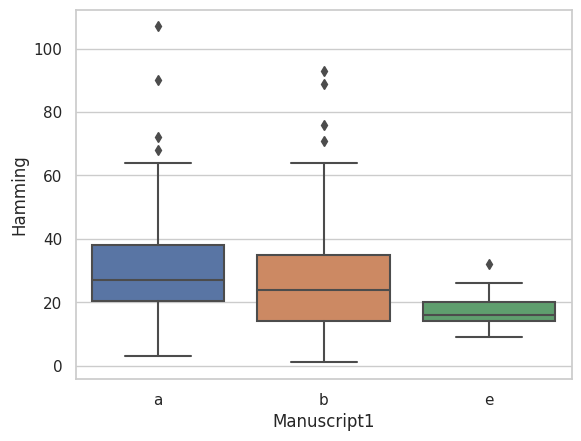

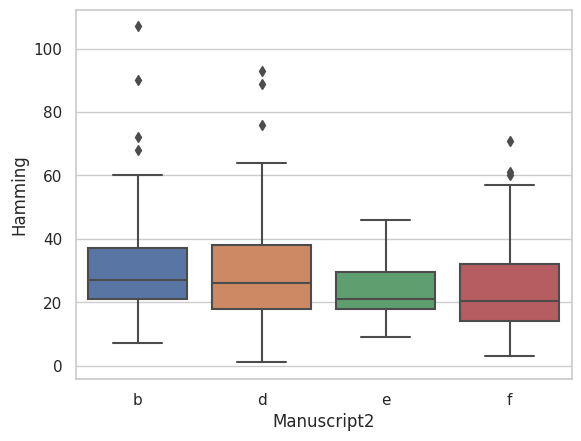

In [15]:
# Create boxplot for hamming distances for Manuscript1 and Manuscript2
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")
ax = sns.boxplot(x="Manuscript1", y="Hamming", data=chap_info_df)
plt.show()
ax = sns.boxplot(x="Manuscript2", y="Hamming", data=chap_info_df)
plt.show()


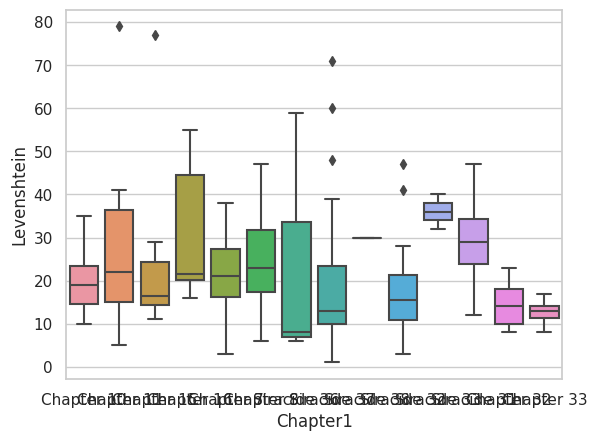

In [16]:
# Create boxplot for levenshtein distances based upon chapter
ax = sns.boxplot(x="Chapter1", y="Levenshtein", data=chap_info_df) 
plt.show()


In [ ]:
# This is building an alternate parser for the XML
# This block is meant for fixing the tags of the <chap>
# This block is for fixing the incorrect tag closing of <chap>
from lxml import etree
import json,re,xmltodict


# First load a document and find the number of chapters the file contains
with open("../data/ms_f.xml",encoding="utf8") as xml_file:

    #read content of file to string
    data = xml_file.read()
    #first replace </chap> with empty
    new_data=data.replace("</chap>","")
    #Then replace <chap> with </chap><chap>
    #Replace first occurrence to restore <chap>
    new_data1=new_data.replace("<chap>","</chap><chap>").replace("</chap><chap>","<chap>",1)
    # To compensate chapter closing replace </Article> with </chap></Article>
    # But this has to be the last occurence so we use rfind
    replacementStr="</chap></Article>"
    new_data1=replacementStr.join(new_data1.rsplit("</Article>", 1))

    #json_data = json.dumps(final_data,ensure_ascii=False,indent=1)
     
    # Write the json data to output
    # json file
    with open("ms_f_new.xml", "w", encoding="utf8") as json_file:
        json_file.write(new_data1)
        json_file.close()
